In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig

D:\Anaconda\envs\llm-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
dataset_name = "financial_phrasebank"

dataset = load_dataset(dataset_name, "sentences_allagree")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [4]:
dataset['train'][0]['sentence']

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [5]:
for i in range(5):
    print(f"Sentence: {dataset['train'][i]['sentence']}")
    print(f"Label: {dataset['train'][i]['label']}")

Sentence: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Label: 1
Sentence: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Label: 2
Sentence: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
Label: 2
Sentence: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .
Label: 2
Sentence: Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .
Label: 2


In [6]:
labels_df = pd.DataFrame()

labels_from_dataset = [dataset['train'][i]['label'] for i in range(2264)]

labels_df['labels'] = labels_from_dataset
labels_df.head()

,labels
0,1
1,2
2,2
3,2
4,2


In [7]:
labels_df['labels'].value_counts()

labels
1    1391
2     570
0     303
Name: count, dtype: int64

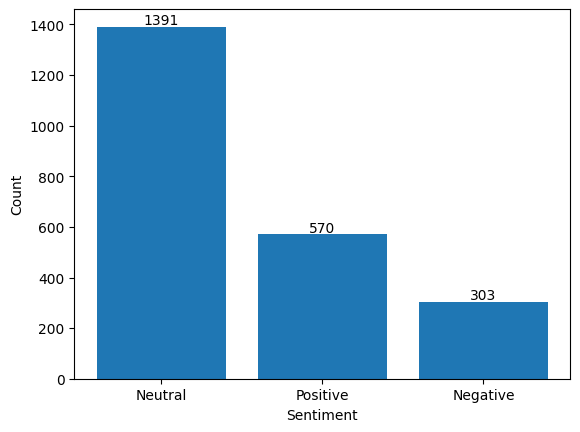

In [8]:
fig, ax = plt.subplots()

x = ['Neutral', 'Positive', 'Negative']
y = [1391, 570, 303]

ax.bar(x,y)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

for i, v in enumerate(y):
    plt.text(x=i, y=v+10, s=str(v), ha='center')

## Load model

In [9]:
model_name = "google/flan-t5-base"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

### Zero-shot inference with prompt engineering

In [11]:
zero_shot_sentiment = []

for i in range(2264):
    sentence = dataset['train'][i]['sentence']

    prompt = f"""
Is the follwing sentence positive, negative or neutral?

{sentence}
    """

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50
        )[0],
        skip_special_tokens=True
    )

    zero_shot_sentiment.append(output)

zero_shot_sentiment[:5]

['negative', 'positive', 'positive', 'positive', 'positive']

In [12]:
labels_df['zero_shot_sentiment'] = zero_shot_sentiment
labels_df['zero_shot_sentiment'] = labels_df['zero_shot_sentiment'].map({'neutral':1, 'positive':2, 'negative':0})

labels_df.head()

,labels,zero_shot_sentiment
0,1,0
1,2,2
2,2,2
3,2,2
4,2,2


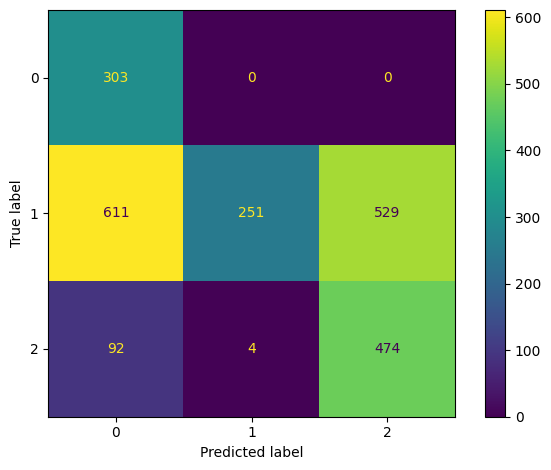

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels_df['labels'], labels_df['zero_shot_sentiment'], labels=[0,1,2])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

In [19]:
from sklearn.metrics import classification_report

clf_report = classification_report(labels_df['labels'], labels_df['zero_shot_sentiment'], labels=[0,1,2])

print(clf_report)

              precision    recall  f1-score   support

           0       0.30      1.00      0.46       303
           1       0.98      0.18      0.30      1391
           2       0.47      0.83      0.60       570

    accuracy                           0.45      2264
   macro avg       0.59      0.67      0.46      2264
weighted avg       0.76      0.45      0.40      2264



### One-shot inference

In [14]:
one_shot_sentiment = []

for i in range(2264):
    sentence = dataset['train'][i]['sentence']

    prompt = f"""

Is the follwing sentence positive, negative or neutral?

Statement: "According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
neutral

Is the follwing sentence positive, negative or neutral?
{sentence}

    """

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50
        )[0],
        skip_special_tokens=True
    )

    one_shot_sentiment.append(output)

one_shot_sentiment[:5]

['positive', 'positive', 'positive', 'positive', 'positive']

In [15]:
labels_df['one_shot_sentiment'] = one_shot_sentiment
labels_df['one_shot_sentiment'] = labels_df['one_shot_sentiment'].map({'neutral':1, 'positive':2, 'negative':0})

labels_df.head()

,labels,zero_shot_sentiment,one_shot_sentiment
0,1,0,2
1,2,2,2
2,2,2,2
3,2,2,2
4,2,2,2


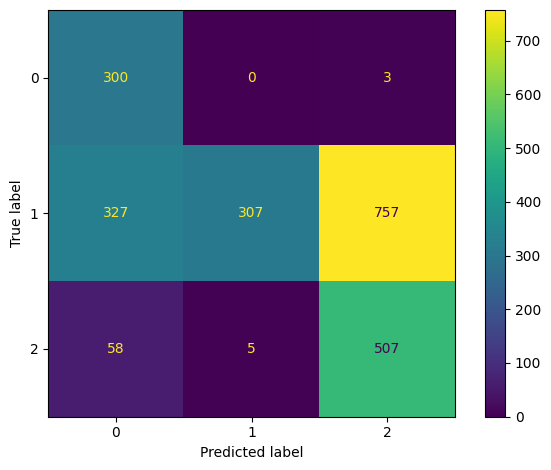

In [16]:
cm = confusion_matrix(labels_df['labels'], labels_df['one_shot_sentiment'], labels=[0,1,2])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

In [20]:
clf_report = classification_report(labels_df['labels'], labels_df['one_shot_sentiment'], labels=[0,1,2])

print(clf_report)

              precision    recall  f1-score   support

           0       0.44      0.99      0.61       303
           1       0.98      0.22      0.36      1391
           2       0.40      0.89      0.55       570

    accuracy                           0.49      2264
   macro avg       0.61      0.70      0.51      2264
weighted avg       0.76      0.49      0.44      2264

